In [1]:
import networkx as nx
import numpy as np
from tqdm import tqdm
import torch
from src.mixturemodel import MixtureModel
from src.sbm import generate_sbm, MySbmFromScratch
from src.utils import random_permute_adj
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from src.metrics import comp_nmi
from src.metrics import comp_nmi_school
mp.set_start_method('spawn', force=True)


In [2]:
k1=11 #from the data

file_path1 = "data/sp_data_school_day_2_g.gexf"
graphe1 = nx.read_gexf(file_path1)
adjacency_matrix1 = nx.adjacency_matrix(graphe1)

adj_tensor1 = torch.tensor(adjacency_matrix1.toarray(), dtype=torch.float32)

model1 = MixtureModel(adj_tensor1, graphe1.number_of_nodes(), k1, device="cuda")



k2=3 #from the data

file_path2 = "data/polbooks.gml"
graphe2 = nx.read_gml(file_path2)
adjacency_matrix2 = nx.adjacency_matrix(graphe2)

adj_tensor2 = torch.tensor(adjacency_matrix2.toarray(), dtype=torch.float32)

model2 = MixtureModel(adj_tensor2, graphe2.number_of_nodes(), k2, device="cuda")

/home/onyxia/work/PGM_MVA-main/ntbk/src/mixturemodel.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float, device=self.device)


In [3]:
list_inits = ["Random", "Sparse", "Kmeans"]
list_model = [model1, model2]
all_res = {}
nmi = {}

for init in list_inits:
    all_res[init] = {}
    nmi[init] = {}

for i, model in enumerate(list_model):

    for init in tqdm(list_inits, desc=f'computing for {model}'):
        resultats = model.em_parallelised_2( return_params=True, init=init, max_it=50, tolerance=1e-4, num_inits=20,
                                            verbose=False)
        all_res[init][model] = model.all_res
        all_res[init][model] = resultats["likelihood"]
        if i==0:
            nmi[init][model] = comp_nmi_school(graphe1, resultats["tau"])
        else:
            nmi[init][model] = comp_nmi(graphe2, resultats["tau"])



omputing for <src.mixturemodel.MixtureModel object at 0x7f54e5f578f0>: 100%|██████████| 3/3 [02:14<00:00, 44.83s/it]

In [4]:
for init in list_inits:
    for i, model in enumerate(list_model):
        print(f"Likelihood with model {i+1} & init {init} :", round(all_res[init][model],2))
        print(f"nmi with model {i+1} & init {init} :", round(nmi[init][model],6))

Likelihood with model 1 & init Random : -9153.1
nmi with model 1 & init Random : 0.694733
Likelihood with model 2 & init Random : -1426.42
nmi with model 2 & init Random : 0.089786
Likelihood with model 1 & init Sparse : -9152.65
nmi with model 1 & init Sparse : 0.719087
Likelihood with model 2 & init Sparse : -1310.66
nmi with model 2 & init Sparse : 0.569285
Likelihood with model 1 & init Kmeans : -9018.88
nmi with model 1 & init Kmeans : 0.703955
Likelihood with model 2 & init Kmeans : -1306.67
nmi with model 2 & init Kmeans : 0.516203


Number of nodes: 238
Number of edges: 5539


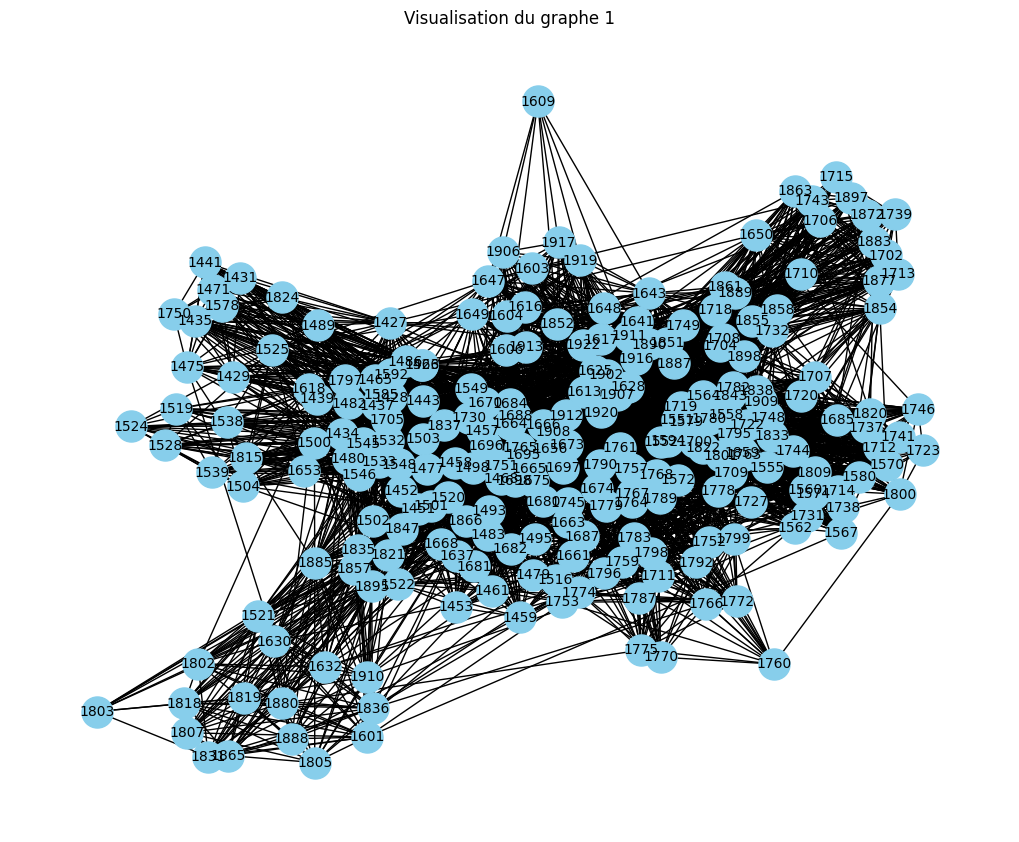

In [5]:
print(f"Number of nodes: {graphe1.number_of_nodes()}")
print(f"Number of edges: {graphe1.number_of_edges()}")

plt.figure(figsize=(10, 8))  # Taille de la figure
nx.draw(graphe1, with_labels=True, node_size=500, node_color="skyblue", font_size=10)
plt.title("Visualisation du graphe 1")
plt.show()

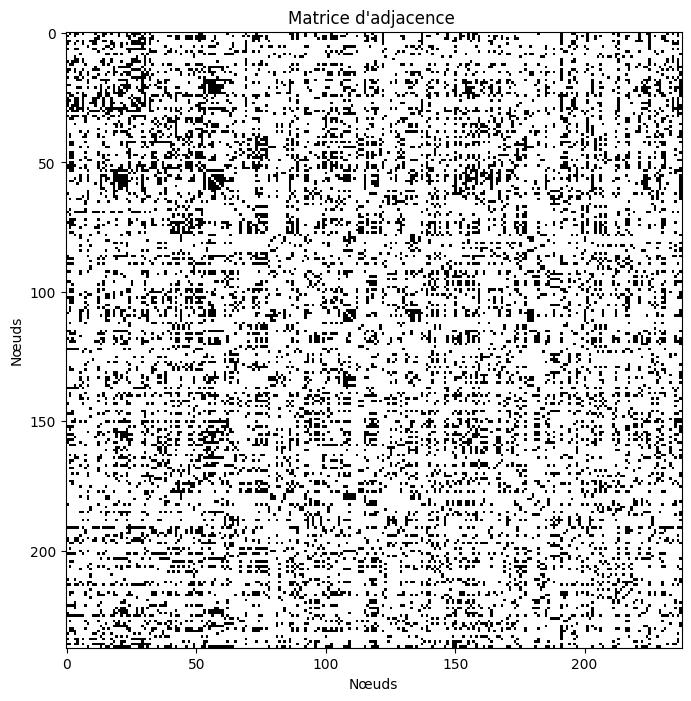

In [6]:
adj_matrix1 = nx.adjacency_matrix(graphe1).toarray()

# Afficher avec Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(adj_matrix1, cmap='binary', interpolation='none')  
plt.title("Matrice d'adjacence ")
plt.xlabel("Nœuds")
plt.ylabel("Nœuds")
plt.show()

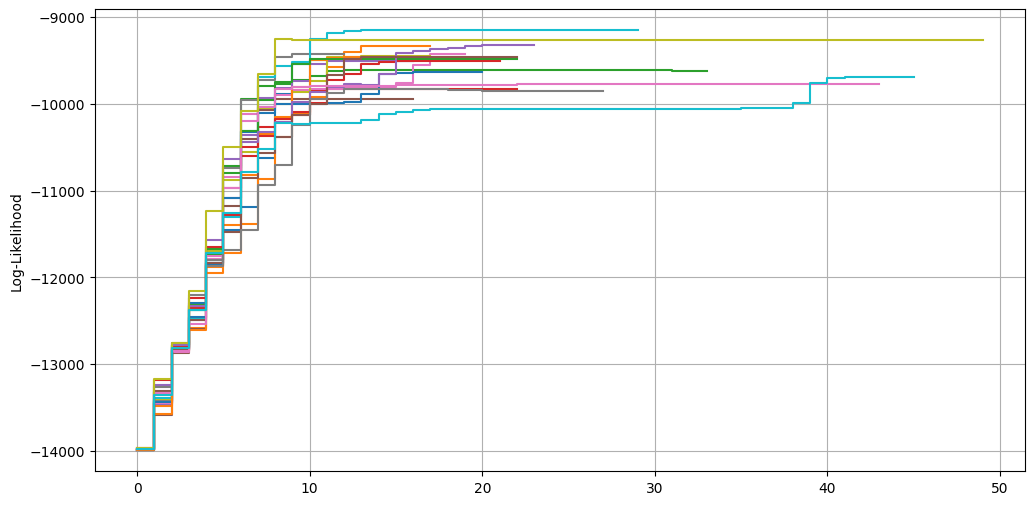

In [7]:
resultats = model1.em_parallelised_2( return_params=True, init="", max_it=50, tolerance=1e-4, num_inits=20, verbose=False)
model1.plot_logs_path()


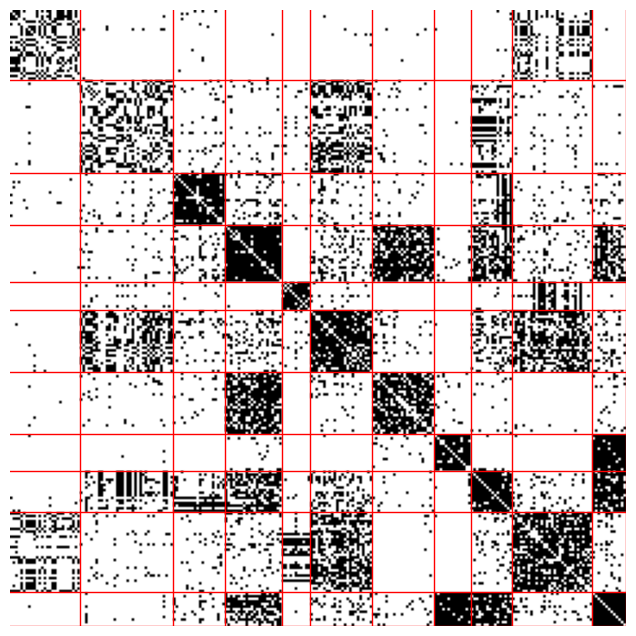

In [8]:
model1.plot_preds_adjancy(resultats["tau"])

In [9]:
comp_nmi_school(graphe1, resultats["tau"])

0.6947333673245543

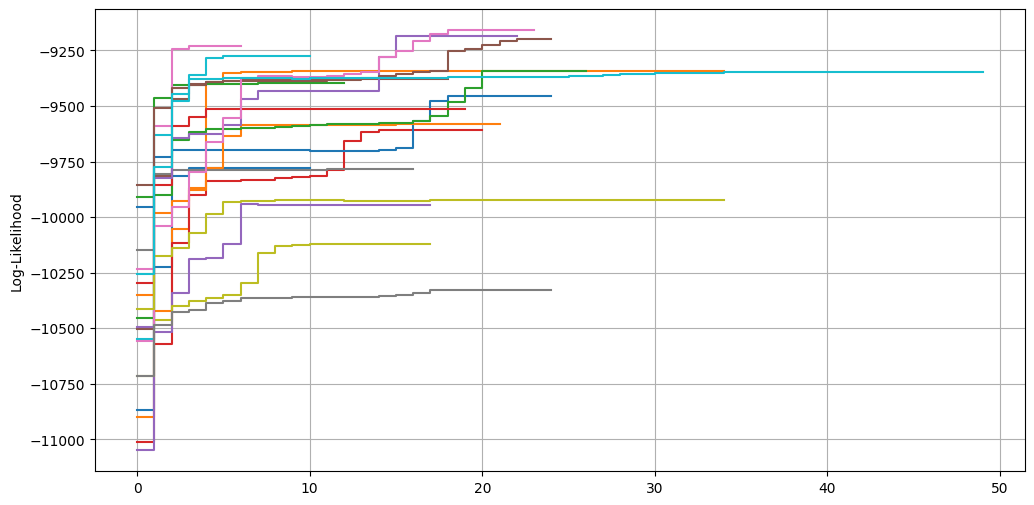

In [10]:
resultats = model1.em_parallelised_2( return_params=True, init="K-means", max_it=50, tolerance=1e-4, num_inits=20, verbose=False)
model1.plot_logs_path()


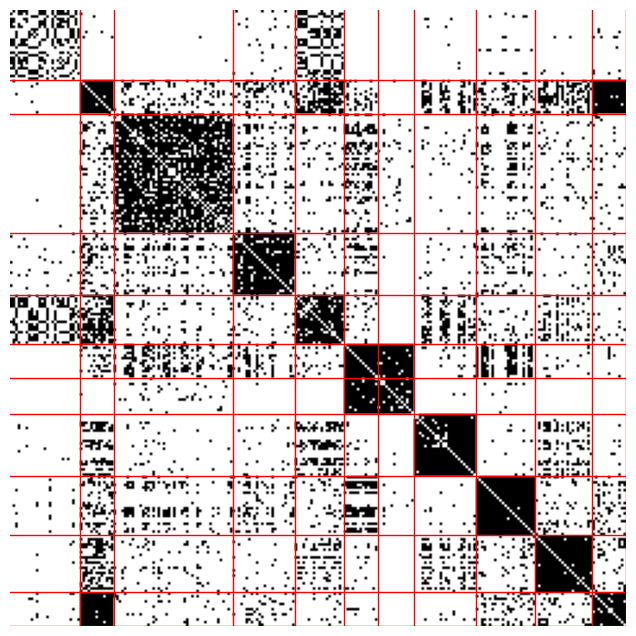

In [11]:
model1.plot_preds_adjancy(resultats["tau"])

In [12]:
comp_nmi_school(graphe1, resultats["tau"])

0.8302321063924479